# Homework 04: Metropolis-Hastings and Cross Validation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import os.path
import subprocess

In [32]:
from sklearn import model_selection, ensemble

Helpers for Getting, Loading and Locating Data

In [3]:
def wget_data(url: str):
    local_path = './tmp_data'
    p = subprocess.Popen(["wget", "-nc", "-P", local_path, url], stderr=subprocess.PIPE, encoding='UTF-8')
    rc = None
    while rc is None:
      line = p.stderr.readline().strip('\n')
      if len(line) > 0:
        print(line)
      rc = p.poll()

def locate_data(name, check_exists=True):
    local_path='./tmp_data'
    path = os.path.join(local_path, name)
    if check_exists and not os.path.exists(path):
        raise RuxntimeError('No such data file: {}'.format(path))
    return path

## <span style="color:Orange">Problem 1</span>

In this problem, you will implement a Metropolis update rule to sample a Markov chain for the un-normalized probability density:
$$
P(x, y) \propto \frac{1}{2} \exp\left[-\frac{(x/s)^2 + (y s)^2}{2}\right] +
\frac{1}{2} \exp\left[-\frac{(x s)^2 + (y/s)^2}{2}\right]
$$
with hyperparameter $s > 0$.

In [4]:
def P(x,y,s):
    return 0.5 * (np.exp(-0.5 * ((x / s) ** 2 + (y * s) ** 2)) + np.exp(-0.5 * ((x * s) ** 2 + (y / s) ** 2)))

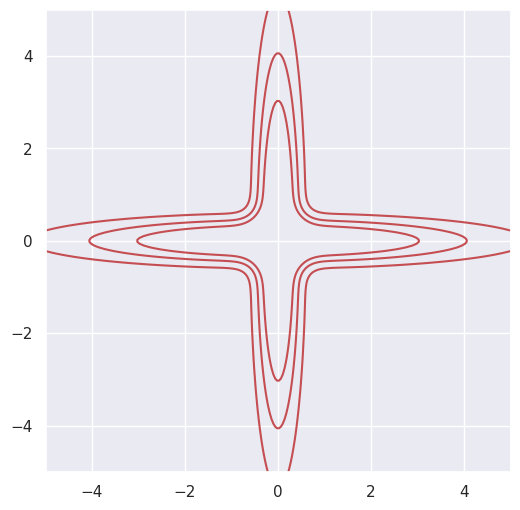

In [5]:
def plot_P(s=3, lim=5):
    fig = plt.figure(figsize=(6, 6))
    xy = np.linspace(-lim, +lim, 250)
    Pxy = P(xy, xy[:, np.newaxis], s)
    plt.contour(xy, xy, Pxy, [0.1, 0.2, 0.3], colors='r')

plot_P()

Implement the function below to perform a Metropolis update starting from $(x,y)$ and using a Gaussian proposal distribution $Q(x,y)$ centered at $(0,0)$ with standard deviation $\sigma$ along both coordinates. Use the "random walk" mode for your proposed updates.  (Recall that Metropolis updates are a special case of Metropolis-Hastings updates where the ratio of $Q$ factors cancels in the Hastings ratio.)

In [6]:
def metropolis_update(x, y, s, gen, sigma=1):
    """Perform a single Metropolis update.

    Parameters
    ----------
    x : float
        Value of x from the previous step.
    y : float
        Value of y from the previous step.
    s : float
        Value of the hyperparameter s.
    gen : np.random.RandomState
        Random state to use for reproducible random samples.
    sigma : float
        Standard deviation of the Gaussian proposal distribution Q(x,y).

    Returns
    -------
    tuple
        Tuple (x,y) of the position after the update.

    """

    # YOUR CODE HERE
    x_proposed = x + gen.normal(0,sigma)
    y_proposed = y + gen.normal(0,sigma)
    p_old= P(x,y,s)
    p_new=P(x_proposed,y_proposed,s)
    accepted_prob= min(1, p_new/p_old)
    if gen.uniform(0,1) < accepted_prob:
        return x_proposed, y_proposed
    else:
        return x,y



    return x_proposed, y_proposed
    raise NotImplementedError()

In [7]:
# A correct solution should pass these tests.
s, n = 3, 1000
gen = np.random.RandomState(seed=123)
# Generate steps from (0, 0) with sigma=1
xy = np.array([metropolis_update(0, 0, s, gen, sigma=1) for i in range(n)])
nrepeat = np.count_nonzero(np.all(xy == [0, 0], axis=1))
assert np.allclose(nrepeat / n, 0.69967, atol=0.1, rtol=0.1)
assert np.allclose(np.mean(xy, axis=0), [0, 0], atol=0.1, rtol=0.1)
# Generate steps from (5, 0) with sigma=1
xy = np.array([metropolis_update(5, 0, s, gen, sigma=1) for i in range(n)])
nrepeat = np.count_nonzero(np.all(xy == [5, 0], axis=1))
assert np.allclose(nrepeat / n, 0.70136, atol=0.1, rtol=0.1)
assert np.allclose(np.mean(xy, axis=0), [4.893, 0], atol=0.1, rtol=0.1)
# Generate steps from (1, -1) with sigma=1
xy = np.array([metropolis_update(1, -1, s, gen, sigma=1) for i in range(n)])
nrepeat = np.count_nonzero(np.all(xy == [1, -1], axis=1))
assert np.allclose(nrepeat / n, 0.26665, atol=0.1, rtol=0.1)
assert np.allclose(np.mean(xy, axis=0), [0.822, -0.822], atol=0.1, rtol=0.1)
# Generate steps from (1, -1) with sigma=2
xy = np.array([metropolis_update(1, -1, s, gen, sigma=2) for i in range(n)])
nrepeat = np.count_nonzero(np.all(xy == [1, -1], axis=1))
assert np.allclose(nrepeat / n, 0.43847, atol=0.1, rtol=0.1)
assert np.allclose(np.mean(xy, axis=0), [0.781, -0.781], atol=0.1, rtol=0.1)

Test your solution with the following visualization:

In [8]:
def plot_chain(update_rule, x0=0, y0=0, s=3, n_updates=200, lim=5, seed=123, **kwargs):
    gen = np.random.RandomState(seed=seed)
    path = [(x0, y0)]
    for i in range(n_updates):
        path.append(update_rule(*path[-1], s, gen, **kwargs))
    plot_P(s, lim)
    x, y = np.array(path).T
    plt.scatter(x, y, s=10, c='k')
    plt.plot(x, y, 'k-', lw=0.5, alpha=0.3)
    plt.xlim(-lim, +lim)
    plt.ylim(-lim, +lim)
    plt.xlabel('$x$')
    plt.ylabel('$y$')

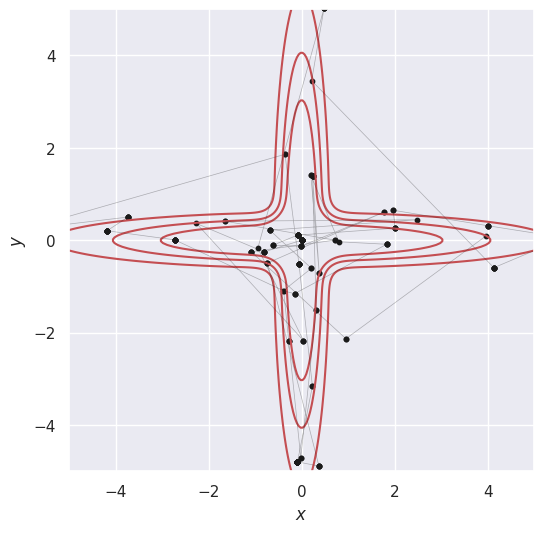

In [9]:
plot_chain(metropolis_update, sigma=2.0)

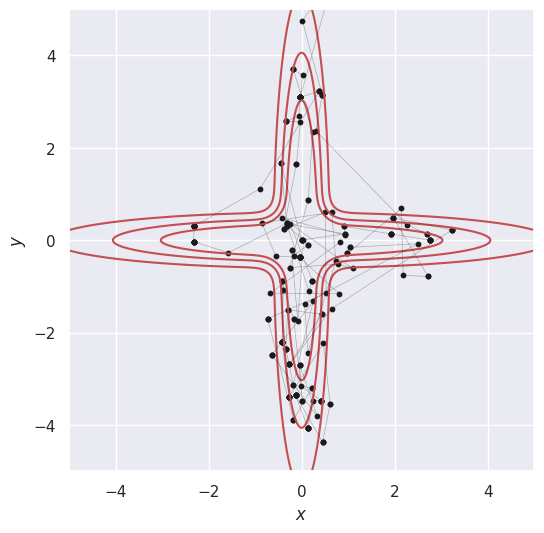

In [10]:
plot_chain(metropolis_update, sigma=1.0)

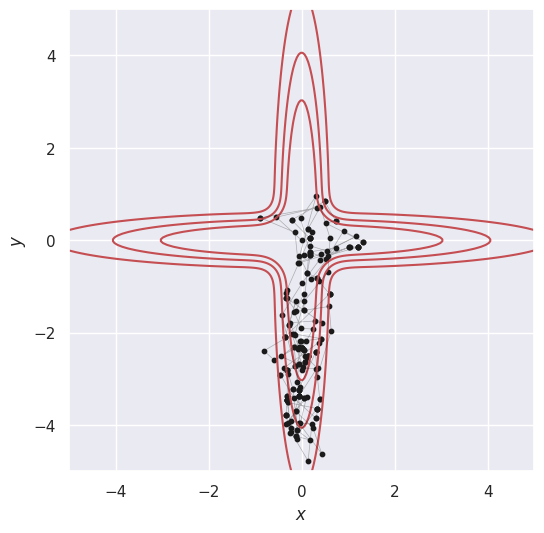

In [11]:
plot_chain(metropolis_update, sigma=0.5)

## <span style="color:Orange">Problem 2</span>

In this problem you will implement a Gibbs update rule for the same probability density.

Implement the function below to sample from the conditional distribution $P(x\mid y)$. Hint: each sample can be drawn from a single Gaussian with $\sigma = s$ or $\sigma = 1/s$ as long as you weight the contributions from each Gaussian correctly given $y$.

In [12]:
def sample_conditional(y, s, gen):
    """Sample from the conditional distribution P(x | y).

    Parameters
    ----------
    y : float
        Fixed value of y to use.
    s : float
        Value of the hyperparameter s.
    gen : np.random.RandomState
        Random state to use for reproducible random samples.

    Returns
    -------
    float
        Random value of x sampled from P(x | y).
    """

    # YOUR CODE HERE
    w1= np.exp(-(y*s)**2/2)
    w2= np.exp(-(y/s)**2/2)
    norm_prob=w1/(w1+w2)
    if gen.uniform() < norm_prob:
        return gen.normal(0,s)
    else:
        return gen.normal(0,1/s)
    return x
    raise NotImplementedError()

In [13]:
# A correct solution should pass these tests.
s, n = 3, 10000
gen = np.random.RandomState(seed=123)
# With y=+/-4, the distribution of x should be narrow.
x = [sample_conditional(+4, s, gen) for i in range(n)]
assert np.allclose(np.percentile(x, (5, 50, 95)), [-0.549, 0, +0.549], atol=0.1, rtol=0.1)
x = [sample_conditional(-4, s, gen) for i in range(n)]
assert np.allclose(np.percentile(x, (5, 50, 95)), [-0.549, 0, +0.549], atol=0.1, rtol=0.1)
# With y=0, the distribution of x should have a narrow core and a wide tail.
x = [sample_conditional(0, s, gen) for i in range(n)]
assert np.allclose(np.percentile(x, (5, 25, 50, 75, 95)), [-3.84, -0.50, 0, +0.50, +3.84], atol=0.1, rtol=0.1)

Implement the function below to perform a Gibbs update consisting of:
 - Sample $x_{n+1}$ from $P_X(x\mid y_n)$
 - Sample $y_{n+1}$ from $P_Y(y\mid x_{n+1})$

Note that you can use `sample_conditional()` for both steps by noticing that $P_Y(y\mid x)$ equals $P_X(x\mid y)$ when $x$ and $y$ are swapped.

In [14]:
def gibbs_update(x, y, s, gen):
    """Perform a single Gibbs update.

    Parameters
    ----------
    x : float
        Value of x from the previous step.
    y : float
        Value of y from the previous step.
    s : float
        Value of the hyperparameter s.
    gen : np.random.RandomState
        Random state to use for reproducible random samples.

    Returns
    -------
    tuple
        Tuple (x,y) of the position after the update.
    """

    # YOUR CODE HERE
    x_new= sample_conditional(y, s, gen)
    y_new= sample_conditional(x_new, s, gen)
    return x_new, y_new
    raise NotImplementedError()

In [15]:
# A correct solution should pass these tests.
s, n = 3, 10000
gen = np.random.RandomState(seed=123)
# Generate steps from (0,0).
xy = np.array([gibbs_update(0, 0, s, gen) for i in range(n)])
assert np.allclose(
    np.percentile(xy[:, 0], (5, 25, 50, 75, 95)),
    [-3.849, -0.502, 0, +0.502, +3.849], atol=0.1, rtol=0.1)
assert np.allclose(
    np.percentile(xy[:, 1], (5, 25, 50, 75, 95)),
    [-2.36, -0.297, 0, +0.297, +2.36], atol=0.1, rtol=0.1)
# Steps from (5,0) have the same distribution.
xy = np.array([gibbs_update(5, 0, s, gen) for i in range(n)])
assert np.allclose(
    np.percentile(xy[:, 0], (5, 25, 50, 75, 95)),
    [-3.849, -0.502, 0, +0.502, +3.849], atol=0.1, rtol=0.1)
assert np.allclose(
    np.percentile(xy[:, 1], (5, 25, 50, 75, 95)),
    [-2.36, -0.297, 0, +0.297, +2.36], atol=0.1, rtol=0.1)
# Steps from (0,-5) have a different distribution.
xy = np.array([gibbs_update(0, -5, s, gen) for i in range(n)])
assert np.allclose(
    np.percentile(xy[:, 0], (5, 25, 50, 75, 95)),
    [-0.548, -0.225, 0, +0.225, +0.548], atol=0.1, rtol=0.1)
assert np.allclose(
    np.percentile(xy[:, 1], (5, 25, 50, 75, 95)),
    [-3.42, -0.391, 0, +0.391, +3.42], atol=0.1, rtol=0.1)

Test your solution with the following visualization:

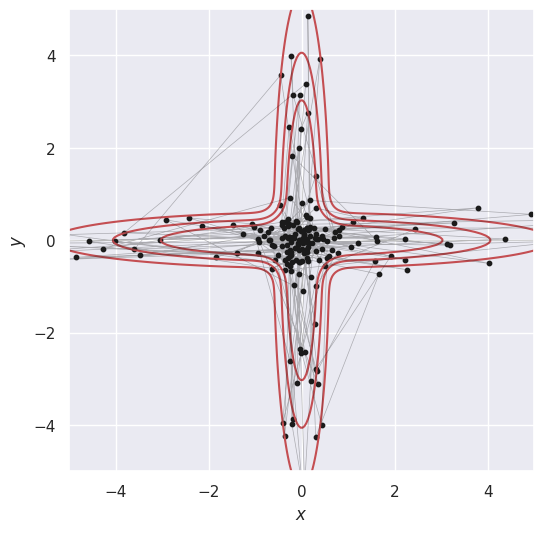

In [16]:
plot_chain(gibbs_update)

## <span style="color:Orange">Problem 3</span>

If we define the potential energy for a "particle" as:
$$
U(x,y) \equiv -\log P(x,y)
$$
it has partial derivatives:
$$
\frac{\partial}{\partial x} U(x,y) = x\, \frac{E_1 / s^2 + E_2 s^2}{E_1 + E_2} \quad, \quad
\frac{\partial}{\partial y} U(x,y) = y\, \frac{E_1 s^2 + E_2 / s^2}{E_1 + E_2}
$$
with
$$
E_1(x,y) \equiv \frac{1}{2} \exp\left[-\frac{(x/s)^2 + (y s)^2}{2}\right] \quad, \quad
E_2(x,y) \equiv \frac{1}{2} \exp\left[-\frac{(x s)^2 + (y/s)^2}{2}\right] \; .
$$
A Hamiltonian MC simulates the trajectory of a particle using the equations of motion:
$$
x \rightarrow x + p_x \Delta t \quad, \quad
y \rightarrow y + p_y \Delta t \quad, \quad
p_x \rightarrow p_x - \frac{\partial}{\partial x} U(x,y) \Delta t \quad, \quad
p_y \rightarrow p_y - \frac{\partial}{\partial y} U(x,y) \Delta t \; ,
$$
where we have set all masses equal to 1 and the temperature $k_B T = 1$.

Implement the function below to perform a single $\Delta t$ step according to the equations above:

In [17]:
def HMC_step(x, y, px, py, s, dt):
    """Perform a single HMC dt step.

    Parameters
    ----------
    x : float
        Current x position.
    y : float
        Current y position.
    px : float
        Current x momentum.
    py : float
        Current y momentum.
    s : float
        Value of the hyperparameter s.
    dt : float
        Step size to take.

    Returns
    -------
    tuple
        Tuple (x, y, px, py) with particle position and momentum after this step.
    """

    e1 = 1/2*np.exp(((-(x/s)**2-(y*s)**2)/2))
    e2 = 1/2*np.exp(((-(x*s)**2-(y/s)**2)/2))

    partialX = x*(e2*(s)**2+e1/s**2)/(e1+e2)
    partialY = y*(e2/(s)**2+e1*s**2)/(e1+e2)

    x += px*dt
    y += py*dt
    px -= partialX*dt
    py -= partialY*dt
    return x, y , px , py

In [18]:
# A correct solution should pass these tests.
assert np.all(HMC_step(0., 0., 0., 0., 3, 1.) == np.array([0.,0.,0.,0.]))
assert np.all(HMC_step(0., 0., 1., 1., 3, 0.) == np.array([0.,0.,1.,1.]))
assert np.all(HMC_step(0., 0., 1., 1., 3, 1.) == np.array([1.,1.,1.,1.]))
assert np.all(HMC_step(0., 0., 1., 1., 3, 2.) == np.array([2.,2.,1.,1.]))
assert np.all(np.round(HMC_step(1., 1., -1., 1., 3, 1.), 3) == np.array([0.,2.,-5.556,-3.556]))
assert np.all(np.round(HMC_step(0., 1., -1., 1., 3, 1.), 3) == np.array([-1.,2.,-1.,0.786]))
assert np.all(np.round(HMC_step(1., 0., -1., 1., 3, 1.), 3) == np.array([0.,1.,-1.214,1.]))

In order to perform an HMC update, we first need to generate random values of the (nuisance) parameters $p_x$ and $p_y$, then we follow the resulting particle from its initial conditions through a fixed number of steps. The result of the update is wherever the particle ends up. Note that the only use of random numbers is to generate the particle's initial momentum.

In [19]:
def HMC_update(x0, y0, s, gen, p_sigma, n_steps, dt):
    """Perform a single HMC update by following a single particle for a fixed time.

    Parameters
    ----------
    x0 : float
        Initial x position.
    y0 : float
        Initial y position.
    s : float
        Value of the hyperparameter s.
    gen : np.random.RandomState
        Random state to use for reproducible random samples.
    p_sigma : float
        Gaussian sigma for generating random initial (px,py) values.
    n_steps : int
        Number of particle steps to simulate.
    dt : float
        Size of each step.

    Returns
    -------
    array
        Array of shape (n_steps + 1, 4) with the particle position and momentum after each step.
    """
    px0, py0 = gen.normal(scale=p_sigma, size=2)
    path = [(x0, y0, px0, py0)]
    for i in range(n_steps):
        path.append(HMC_step(*path[-1], s, dt))
    return np.array(path)

Finally, use the following visualization to see the particle trajectories from different updates:

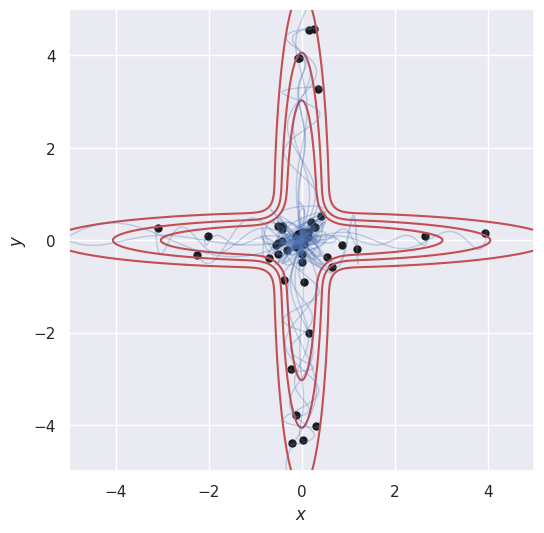

In [20]:
def plot_HMC(x0=0, y0=0, s=3, p_sigma=1., n_steps=500, dt=0.01, n_updates=50, lim=5, seed=3, **kwargs):
    gen = np.random.RandomState(seed=seed)
    plot_P(s, lim)
    for i in range(n_updates):
        path = HMC_update(x0, y0, s, gen, p_sigma, n_steps, dt)
        x, y, px, py = np.array(path).T
        plt.scatter(x[-1], y[-1], s=25, c='k')
        plt.plot(x, y, 'b-', lw=1, alpha=0.3)
    plt.xlim(-lim, +lim)
    plt.ylim(-lim, +lim)
    plt.xlabel('$x$')
    plt.ylabel('$y$')

plot_HMC()

## <span style="color:Orange">Problem 4</span>

The default score function used by sklearn to evaluate how well a regression model predicts data is the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) $R^2$. Implement the function below to calculate $R^2$:

In [21]:
def calculate_R2(y_data, y_pred):
    """Calculate the coefficient of determination R2 for two arrays.

    Parameters
    ----------
    y_data : array
        Array of data values, must have the same shape as y_pred.
    y_pred : array
        Array of predicted values, must have the same shape as y_data.

    Returns
    -------
    float
        Calculated coefficient of determination R2.
    """
    assert y_data.shape == y_pred.shape

    # YOUR CODE HERE
    mean_y= np.mean(y_data)
    num= np.sum((y_data-y_pred)**2)
    den= np.sum((y_data-mean_y)**2)
    R2= 1-(num/den)
    return R2
    raise NotImplementedError()

In [22]:
# A correct solution should pass the tests below.
gen = np.random.RandomState(seed=123)
N = 100
x = gen.uniform(size=N)
y_pred = 2 * x - 1
y_data = y_pred + gen.normal(scale=0.1, size=N)
assert np.round(calculate_R2(y_data, y_pred), 3) == 0.961
assert np.round(calculate_R2(y_data, -y_pred), 3) == -2.935
assert np.round(calculate_R2(y_pred, y_pred), 3) == 1.000
assert np.round(calculate_R2(y_pred, -y_pred), 3) == -3.000
assert np.round(calculate_R2(y_data, np.full(N, np.mean(y_pred))), 3) == 0.000

## <span style="color:Orange">Problem 5</span>

Implement the function below to perform a [grid-search cross validation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) of a [random forest regression](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) over the following grid:
 - `min_samples_leaf` = 1, 10, 20
 - `n_estimators` = 5, 10, 15

Hint: you will need to ensure reproducible "random" behavior in order to pass all the tests.

In [23]:
def cv_summary(cv):
    """Summarize the results from a GridSearchCV fit.

    Summarize a cross-validation grid search in a pandas DataFrame with the
    following transformations of the full results:
      - Remove all columns with timing measurements.
      - Remove the 'param_' prefix from column names.
      - Remove the '_score' suffix from column names.
      - Round scores to 3 decimal places.

     If the parameter grid is 1D, then this function also plots the test
     and training R2 scores versus the parameter.

    Parameters
    ----------
    cv : sklearn.model_selection.GridSearchCV
        Instance of a GridSearchCV object that has been fit to some data.

    Returns
    -------
    pandas.DataFrame
        Summary table of cross-validation results.
    """
    # Look up the list of parameters used in the grid.
    params = list(cv.cv_results_['params'][0].keys())
    # Index results by the test score rank.
    index = cv.cv_results_['rank_test_score']
    df = pd.DataFrame(cv.cv_results_, index=index).drop(columns=['params', 'rank_test_score'])
    # Remove columns that measure running time.
    df = df.drop(columns=[n for n in df.columns.values if n.endswith('_time')])
    # Remove param_ prefix from column names.
    df = df.rename(lambda n: n[6:] if n.startswith('param_') else n, axis='columns')
    # Remove _score suffix from column names.
    df = df.rename(lambda n: n[:-6] if n.endswith('_score') else n, axis='columns')
    if len(params) == 1:
        # Plot the test and training scores vs the grid parameter when there is only one.
        plt.plot(df[params[0]], df['mean_train'], 'o:', label='train')
        plt.plot(df[params[0]], df['mean_test'], 'o-', label='test')
        plt.legend(fontsize='x-large')
        plt.xlabel('Hyperparameter value')
        plt.ylabel('Score $R^2$')
        plt.ylim(max(-2, np.min(df['mean_test'])), 1)
    return df.sort_index().round(3)

In [35]:
import sklearn
def cross_validate(X, Y, gen):
    """Perform cross validation of a random forest regression.

    Parameters
    ----------
    X : array
        Array with shape (N, DX) of N samples with DX features.
    Y : array
        Array with shape (N, DY) of N samples with DY features.
    gen : np.random.RandomState
        Random state to use for reproducible random numbers.

    Returns
    -------
    pandas.DataFrame
        Cross-validation summary table produced by cv_summary().
    """
    assert len(X) == len(Y)

    # YOUR CODE HERE

    param= {
        'min_samples_leaf': [1,10,20],
        'n_estimators': [5,10,15]

    }
    regressor= ensemble.RandomForestRegressor(random_state=gen)
    grid_search=model_selection.GridSearchCV(regressor, param, cv=2,return_train_score=True)
    grid_search.fit(X,Y)


    return cv_summary(grid_search)


    raise NotImplementedError()

In [25]:
wget_data('https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/data/spectra_data.hf5')
wget_data('https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/data/spectra_targets.hf5')

--2024-02-22 05:57:19--  https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/data/spectra_data.hf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414744 (405K) [application/octet-stream]
Saving to: ‘./tmp_data/spectra_data.hf5’
     0K .......... .......... .......... .......... .......... 12% 3.26M 0s
    50K .......... .......... .......... .......... .......... 24% 7.10M 0s
   100K .......... .......... .......... .......... .......... 37% 10.8M 0s
   150K .......... .......... .......... .......... .......... 49% 10.1M 0s
   200K .......... .......... .......... .......... .......... 61% 20.1M 0s
   250K .......... .......... .......... .......... .......... 74% 21.0M 0s
   300K .......... .......... .......... .......... .....

In [26]:
X = pd.read_hdf(locate_data('spectra_data.hf5')).values
Y = pd.read_hdf(locate_data('spectra_targets.hf5')).values

In [36]:
# A correct solution should pass the tests below.
gen = np.random.RandomState(seed=123)
cvs = cross_validate(X, Y, gen)
assert np.all(cvs.columns.values == [
    'min_samples_leaf', 'n_estimators', 'split0_test', 'split1_test',
    'mean_test', 'std_test', 'split0_train', 'split1_train', 'mean_train',
    'std_train'])
assert np.all(cvs['min_samples_leaf'].values == [1, 1, 1, 10, 10, 10, 20, 20, 20])
assert np.all(cvs['n_estimators'].values == [15, 10, 5, 15, 10, 5, 15, 10, 5])
assert np.allclose(
    cvs['mean_test'].values,
    [0.961, 0.955, 0.942, 0.896, 0.891, 0.879, 0.496, 0.490, 0.480], atol=1e-3)
assert np.allclose(
    cvs['mean_train'].values,
    [0.993, 0.992, 0.990, 0.909, 0.908, 0.905, 0.512, 0.515, 0.507], atol=1e-3)

## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer

© Copyright 2024